In [10]:
import pandas as pd
import datetime
import ccxt
from datetime import datetime, timezone, timedelta


import pandas as pd
import pandas_ta as ta
import time 
import json
import numpy as np

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
exchange="bitmex"
with open('./file_bitmex.json') as f:
    data = json.load(f)

    # Access the values from the loaded JSON data
    key_value = data["key"]
    secret_value = data["secret"]
    password_file = data["password"]

exchange_conn = eval(f'ccxt.{exchange}')({
            'enableRateLimit': True, 
            'options': {
                'adjustForTimeDifference': True,
                'recvWindow': 50000,
                'defaultType': 'swap',    
                'timeDifference': 5000
            },
            'apiKey': key_value,
            'secret': secret_value 
            })


In [12]:
data=exchange_conn.fetch_ohlcv('XBTUSDT', '1h', since=None, limit=1000)
data=pd.DataFrame(data,columns=['datetime','Open','High','Low','Close','Volume'])
data

,datetime,Open,High,Low,Close,Volume
0,1711544400000,70258.2,71883.9,69716.7,69953.7,260854000.0
1,1711548000000,69953.7,70282.0,68632.7,70128.5,132902000.0
2,1711551600000,70128.5,70159.3,68932.2,68957.5,67319000.0
3,1711555200000,68957.5,69334.9,68422.9,69315.9,76077000.0
4,1711558800000,69315.9,69468.9,68656.0,68724.0,23850000.0
...,...,...,...,...,...,...
995,1715126400000,62316.0,62667.6,62088.5,62574.6,41915000.0
996,1715130000000,62574.6,62675.0,62418.0,62511.4,6341000.0
997,1715133600000,62511.4,62819.2,62501.1,62745.1,12377000.0
998,1715137200000,62745.1,62965.1,62551.5,62849.3,8768000.0


In [13]:
len = 15
FfastLength = 8
FslowLength = 21
FsignalLength = 9
tuning_ema=55

ema1 = ta.ema(data.Close, len)
ema2 = ta.ema(ema1, len)
ema3 = ta.ema(ema2, len)


ema_filter=ta.ema(data.Close,tuning_ema)
avg = 3 * (ema1 - ema2) + ema3


Fsource = data.Close
FfastMA = ta.ema(Fsource, FfastLength)
FslowMA = ta.ema(Fsource, FslowLength)
Fmacd = FfastMA - FslowMA
Fsignal = ta.sma(Fmacd, FsignalLength)

data['Fmacd'] = Fmacd
data['Fsignal'] = Fsignal
data['avg'] = avg
data['ema_filter']=ema_filter

# Shift the columns to get the previous values
data['Fmacd_prev'] = data['Fmacd'].shift(1)
data['Fsignal_prev'] = data['Fsignal'].shift(1)
data['avg_prev'] = data['avg'].shift(1)

# Apply the function row-wise
data['long_signal'] = ta.cross_value(data['Fmacd'], data['Fsignal']) & ta.cross_value(data['avg'], data['avg_prev'])
data['short_signal'] = ta.cross_value(data['Fsignal'], data['Fmacd']) & ta.cross_value(data['avg_prev'], data['avg'])

islong=False
isShort=False


if data['long_signal'].iloc[-1] and data.Close.iloc[-1]>ema_filter.iloc[-1]:
    islong=True
    print("long")

elif data['short_signal'].iloc[-1] and data.Close.iloc[-1]<ema_filter.iloc[-1]:
    isShort=True
    print("short")

elif data['long_signal'].iloc[-1] and islong:
    print("close long")

elif data['short_signal'].iloc[-1] and isShort:
    print("close short")




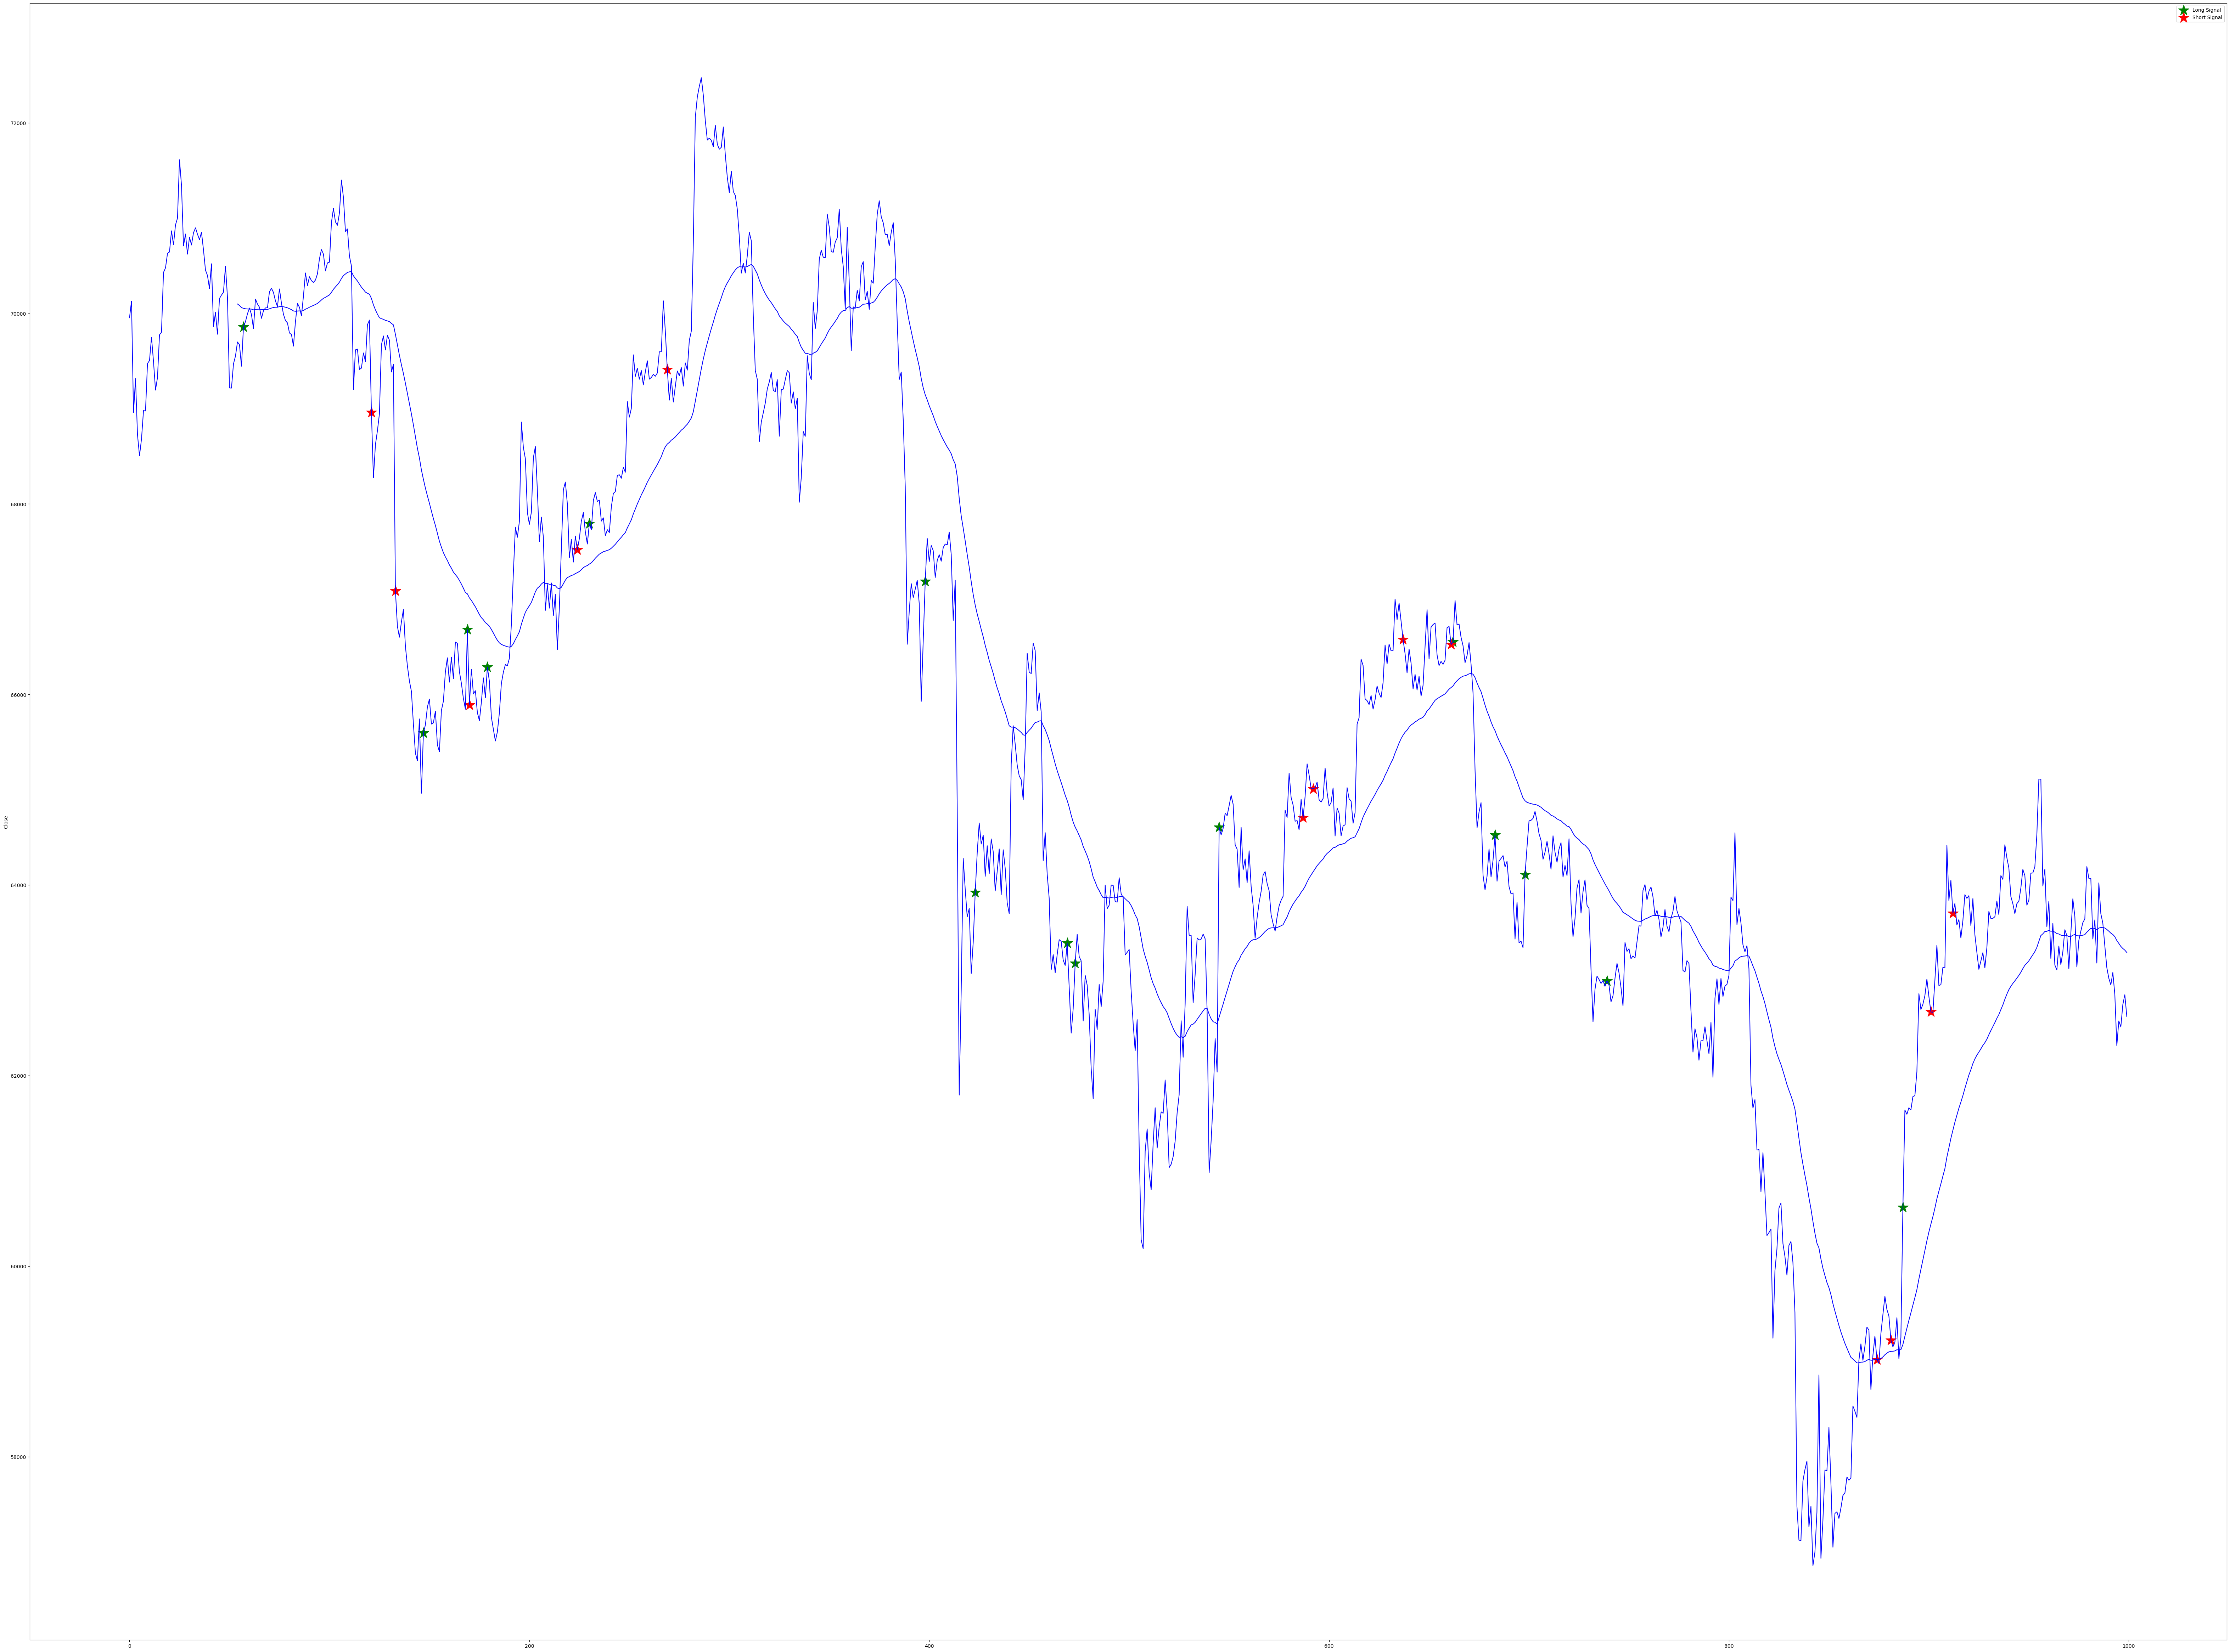

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(80, 60))
sns.lineplot(data=data, x=data.index, y='Close', color='blue')  # Plot the lineplot without markers
sns.lineplot(data=data, x=data.index, y='ema_filter', color='blue')  # Plot the lineplot without markers

# Plot markers at True values of long_signal and short_signal
true_values_long = data[data.long_signal == 1].index
true_values_short = data[data.short_signal == 1].index

# Find the intersection of indices where both long_signal and short_signal are 1
true_values_both = data[(data.long_signal == 1) & (data.short_signal == 1)].index

plt.scatter(true_values_long, data[data.long_signal==1].Close, color='green', marker='*', label='Long Signal', s=500)
plt.scatter(true_values_short, data[data.short_signal==1].Close, color='red', marker='*', label='Short Signal', s=500)

plt.legend()
plt.show()


In [15]:
ta.xsignals??

Signature:
ta.xsignals(
    signal,
    xa,
    xb,
    above: bool = True,
    long: bool = True,
    asbool: bool = None,
    trend_reset: int = 0,
    trade_offset: int = None,
    offset: int = None,
    **kwargs,
)
Docstring:
Cross Signals (XSIGNALS)

Cross Signals returns Trend Signal (TSIGNALS) results for Signal Crossings. This
is useful for indicators like RSI, ZSCORE, et al where one wants trade Entries
and Exits (and Trends).

Cross Signals has two kinds of modes: above and long.

The first mode 'above', default True, xsignals determines if the signal first
crosses above 'xa' and then below 'xb'. If 'above' is False, xsignals determines
if the signal first crosses below 'xa' and then above 'xb'.

The second mode 'long', default True, passes the long trend result into
tsignals so it can determine the appropriate Entries and Exits. When 'long' is
False, it does the same but for the short side.

Example:
# These are two different outcomes and depends on the indicator and it's
#